# Movielens Recommendation System 

In [4]:
# Import Data
import tensorflow as tf
from zipfile import ZipFile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import get_file
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

In [2]:
# Loading the Data
URL = "http://files.grouplens.org/datasets/movielens/ml-20m.zip"
movielens_path = get_file("movielens20m.zip", URL, extract=True)

In [3]:
# Reading and Processing the Data
with ZipFile(movielens_path) as z:
    with z.open("ml-20m/ratings.csv") as f:
        df = pd.read_csv(f)
# Movie and user id's deduplication               
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

In [21]:
# New mapping application to join the index ID to the encoded ID  
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}


df["user"] = df["userId"].map(user2user_encoded)
num_users = len(user_encoded2user)
df["movie"] = df["movieId"].map(movie2movie_encoded)
num_movies = len(movie_encoded2movie)

# Normalizing the ratings
min_rating, max_rating = df["rating"].min(), df["rating"].max()

df["rating"] = df["rating"].apply(lambda x:(x-min_rating)/(max_rating-min_rating))

In [22]:
# Train/Test Split
X = df[["user", "movie"]].values
y = df["rating"].values
(x_train, x_val, y_train, y_val) = train_test_split(X, y,test_size=0.1,random_state=42)

In [ ]:
# Buiding model using collaborative filtering architecture

class RecommenderNet(tf.keras.Model):
  # __init function is to initialize the values of instance members for the new object
    def __init__(self, num_users, num_movies, embedding_size,**kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        # Variable for embedding size
        self.embedding_size = embedding_size
        # Variables for user count, and related weights and biases
        self.num_users = num_users
        self.user_embedding = Embedding(num_users,embedding_size,embeddings_initializer="he_normal",embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
        self.user_bias = Embedding(num_users, 1)
        # Variables for movie count, and related weights and biases
        self.num_movies = num_movies
        self.movie_embedding = Embedding(num_movies,embedding_size,embeddings_initializer="he_normal",embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
        self.movie_bias = Embedding(num_movies, 1)
    def call(self, inputs):
        # call function is for the dot products of user and movie vectors
        # It also accepts the inputs, feeds them into the layers,and feed into the final sigmoid layer
        # User vector and bias values with input values
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        # Movie vector and bias values with input values
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        # tf.tensordot calculcates the dot product
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

### Hyperparameter tuning for faster and better results
     1) optimizer: SGD, Adam, NAdam and Adamax
     2) learning rate: 0.001, 0.01
     3) batch size: 1024, 4096

### Metrics Selection:

MAE: It is the difference between the actual value(rating) and the predicted value. One large characteristic of MAE does not give any bias to ourliers. If there are outliers, it will weigh those equally to the other predictions. Since we aren't looking for any outliers MAE is preffered here. 

Hit Rate is a better alternative to MAE or RMSE. But it good to remember that however good the alternative may be, we are not exactly measuring what we want. 

Epoch 1/25
17579/17579 - 1554s - loss: 0.0512 - mae: 0.1798 - val_loss: 0.0481 - val_mae: 0.1729
Epoch 2/25
17579/17579 - 1541s - loss: 0.0469 - mae: 0.1704 - val_loss: 0.0461 - val_mae: 0.1688
Epoch 3/25
17579/17579 - 1541s - loss: 0.0454 - mae: 0.1670 - val_loss: 0.0450 - val_mae: 0.1662
Epoch 4/25
17579/17579 - 1540s - loss: 0.0445 - mae: 0.1649 - val_loss: 0.0442 - val_mae: 0.1644
Epoch 5/25
17579/17579 - 1540s - loss: 0.0438 - mae: 0.1633 - val_loss: 0.0436 - val_mae: 0.1630
Epoch 6/25
17579/17579 - 1541s - loss: 0.0433 - mae: 0.1621 - val_loss: 0.0431 - val_mae: 0.1619
Epoch 7/25
17579/17579 - 1540s - loss: 0.0428 - mae: 0.1611 - val_loss: 0.0427 - val_mae: 0.1610
Epoch 8/25
17579/17579 - 1540s - loss: 0.0424 - mae: 0.1602 - val_loss: 0.0424 - val_mae: 0.1602
Epoch 9/25
17579/17579 - 1544s - loss: 0.0421 - mae: 0.1595 - val_loss: 0.0421 - val_mae: 0.1596
Epoch 10/25
17579/17579 - 1540s - loss: 0.0418 - mae: 0.1589 - val_loss: 0.0418 - val_mae: 0.1590
Epoch 11/25
17579/17579 - 153

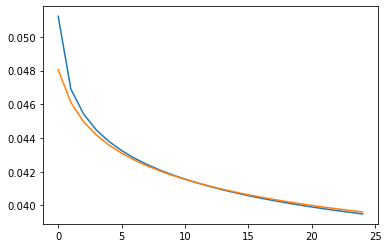

In [86]:
# SGD optimizer (Takes ~4-6 Hours)
model = RecommenderNet(num_users, num_movies, embedding_size=50)

# Compile and Train the Model
model.compile(loss='mse',metrics=['mae'],optimizer=tf.keras.optimizers.SGD(learning_rate=0.08, momentum=0.9))


history = model.fit(x=x_train,y=y_train,batch_size=1024,epochs=25,verbose=2,validation_data=(x_val, y_val))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

Epoch 1/5
4395/4395 [==============================] - 1186s 269ms/step - loss: 0.6290 - mae: 0.1844 - val_loss: 0.6181 - val_mae: 0.1742
Epoch 2/5
4395/4395 [==============================] - 1133s 258ms/step - loss: 0.6136 - mae: 0.1691 - val_loss: 0.6129 - val_mae: 0.1699
Epoch 3/5
4395/4395 [==============================] - 1142s 260ms/step - loss: 0.6084 - mae: 0.1625 - val_loss: 0.6080 - val_mae: 0.1635
Epoch 4/5
4395/4395 [==============================] - 1158s 263ms/step - loss: 0.6060 - mae: 0.1594 - val_loss: 0.6071 - val_mae: 0.1626
Epoch 5/5
4395/4395 [==============================] - 1102s 251ms/step - loss: 0.6050 - mae: 0.1578 - val_loss: 0.6063 - val_mae: 0.1611


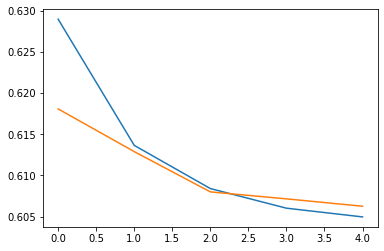

In [90]:
# Adam Optimizer Takes ~1.1 Hours
model = RecommenderNet(num_users, num_movies, embedding_size=125)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(
    metrics=['mae'],
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=4096,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

The loss curve looks sensible and model has converged. 

In [115]:
model.save("../models/",save_format="tf")

INFO:tensorflow:Assets written to: ../models/assets


In [116]:
user_id = df.userId.sample(1).iloc[0]
print("Recommend movies for user: ", user_id)

Recommend movies for user:  56622


In [117]:
movies_watched = df[df.userId == user_id]
not_watched = df[~df['movieId'].isin(movies_watched.movieId.values)]['movieId'].unique()
not_watched = [[movie2movie_encoded.get(x)] for x in not_watched]

In [118]:
# To avoid showing previously seen movies
print('Movie: ',len(not_watched))

# generate the predicted movie ratings
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(([[user_encoder]] * len(not_watched), not_watched ))
ratings = model.predict(user_movie_array).flatten()

Movie:  26693


In [109]:
# Top 5 recommendations sorted by rating order
top5_indices = ratings.argsort()[-5:][::-1]
recommended_movie_ids = [movie_encoded2movie.get(not_watched[x][0]) for x in top5_indices]

#### Top recommendations

In [119]:
# Show top results
with ZipFile(movielens_path) as z:
    with z.open("ml-20m/movies.csv") as f:
        movie_df = pd.read_csv(f)

recommended_movies = movie_df[movie_df["movieId"].
isin(recommended_movie_ids)]
print("Top 5 movie recommendations")
print(recommended_movies[['title']])

Top 5 movie recommendations
                                 title
49          Usual Suspects, The (1995)
315   Shawshank Redemption, The (1994)
523            Schindler's List (1993)
843              Godfather, The (1972)
1195    Godfather: Part II, The (1974)


#### Potential Imporvements

1) Improved Ranking using algorithms like Scann index

2) Toggles to filter movies based of age guidance

3) Connect with data from external sources such as wikipedia and imdb to imporve the encoded strings to improve search results

4) Use BERT to create embeddings for sentenses, this would allow us to use and recommend non-English titles.

#### Approach for 20k and 200k

20k: Since Collaborative Filtering suffers from Cold-start and data sparsity problem at this sample size. I'd test a content based approach. If that doesn't perform well I'd simply build a a filtering recommandation that shows the top movies from the genre that the user has not seen. I beallive for 200k collaborative filter approach would be suitable,  In order to deal with sparcity, I will apply dimensionality reduction techniques to capture more signals from the big dataset. Model-Based Collaborative Filtering would be better suited for 200k samples.